In [ ]:
# default_exp image

# image

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import cv2
import numpy as np
import random
from fastai.data.all import *
from pathlib import Path
import PIL
import cv2
from IPython.core.debugger import set_trace
from functools import partial
from numpy import isclose

In [ ]:
import PIL.ImageOps

In [ ]:
URL = Path("/Users/id/nbs/06-chess-vision/chessocr/examples")
URL = Path("/Users/id/.fastai/data/chess_screenshots_tiny")
URL = Path("/Users/id/screenshots/chess-screenshots/data")
URL = Path("/Users/id/.fastai/data/kaggle-chess/train")

In [ ]:
fnames = get_image_files(URL)

In [ ]:
#export
def drawContour(image, contour, color=(255, 0, 0), thickness=4):
    for i in range(len(contour)):
        p1 = contour[i]
        p2 = contour[int((i+1) % len(contour))]
        cv2.line(image, p1.ravel(), p2.ravel(), color, thickness)

In [ ]:
#export
def line_filter(lines): 
    return [isclose(line[1], 0, rtol=1e-4) 
            or isclose(line[1], np.pi/2, rtol=1e-4) 
            for line in lines]

In [ ]:
#export
def contourFilter(contour, min_ratio):
    _,_,w,h = tmp = cv2.boundingRect(contour)
    if w == 0 or h == 0:
        return -1
    ratio = min(w,h)/float(max(w,h))
    area = cv2.contourArea(contour)
    return ratio > min_ratio and area > 2000

In [ ]:
#export
class Image:
    def __init__(self, fname):
        """ init from file """
        border = random.randint(10, 100)
        self.fname = fname
        self.orig = PIL.ImageOps.expand(PIL.Image.open(self.fname), (border, border))
        self.i = np.array(self.orig).copy()
        self.i_gray = cv2.cvtColor(self.i, cv2.COLOR_BGR2GRAY)
        mean = self.i_gray[border:-border, border:-border].mean()
        thresh, self.i_bw = cv2.threshold(self.i_gray, mean, 255, cv2.THRESH_BINARY)
        self.drawContours()
        lines = cv2.HoughLines(self.i_con, 3, np.pi/180, 200).squeeze(1)
        self.i_hough = self.i # np.zeros(self.i_bw.shape, dtype=np.uint8)
        self.draw_hough_lines(lines)
        
        
    def display(self, size=(200, 200)):
        fig = plt.figure(figsize=(15, 8))
        gs = fig.add_gridspec(1, 5)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(self.orig)
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(self.i_gray, cmap='gray')
        
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.imshow(self.i_bw, cmap='gray')
        
        ax4 = fig.add_subplot(gs[0, 3])
        ax4.imshow(self.i_con, cmap='gray')
        
        ax5 = fig.add_subplot(gs[0, 4])
        ax5.imshow(self.i_hough, cmap='gray')
        ax5.set_title(f"{len(self.lines)}")

        for ax in [ax1, ax2, ax3, ax4, ax5]:
            ax.set_xticks([])
            ax.set_yticks([])
    
    
    def drawContours(self, color='red', thickness=2):
        self.i_con = np.zeros(self.i.shape[:2], dtype=np.uint8)
        contours, hierarchy = cv2.findContours(self.i_bw,  cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
        f = partial(contourFilter, min_ratio=0.5)
        self.contours = list(filter(f, contours))
        red = (255, 0, 0)
        for contour in self.contours:
            drawContour(self.i_con, contour, red, thickness=2)

    
    def draw_hough_lines(self, lines):
        lines = lines[line_filter(lines)]
        lines = lines[lines[:, 0].argsort()[::-1]]
        self.lines = lines
        for line in self.lines:
            rho, theta = list(line)
            if isclose(theta, 0.0):
                x1 = 0
                y1 = y2 = int(rho)
                x2 = 4000
            elif isclose(theta, np.pi/2):
                y1 = 0
                y2 = 4000
                x1 = x2 = int(rho)
            cv2.line(self.i_hough, (x1, y1), (x2, y2), (255, 0, 0), 2)

    
    def __repr__(self):
        return f"{self.fname}"

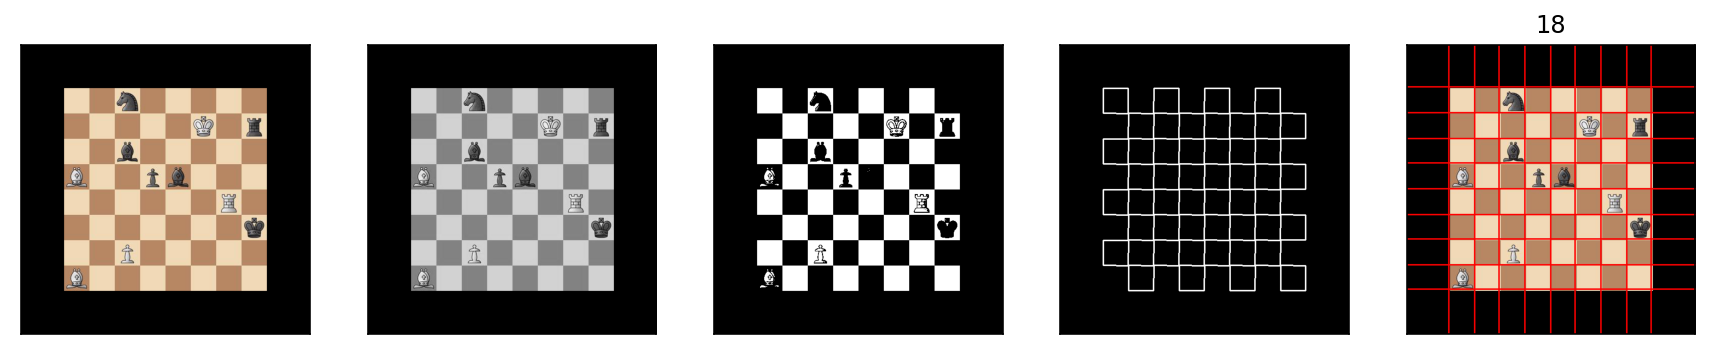

In [ ]:
idx = random.randint(0, len(fnames))
Image(fnames[idx]).display()